In [1]:
# Блокнот демонстрирует функционал использования класса PoseMultiple на примере кадов с рендера

In [1]:
# Импортирование модулей

In [2]:
import os, sys
base_dir = os.path.split(os.getcwd())[0]
os.chdir(os.path.join(base_dir))

In [4]:
import pickle as pk

import numpy as np
import cv2
import sys
import argparse
import time
import copy
import datetime
import yaml
from time import time

import matplotlib.pyplot as plt

from cranpose.utils import ARUCO_DICT, display_pose
from cranpose.estimators import PoseSingle, PoseMultiple, PoseSpecial

In [5]:
from scipy.spatial.transform import Rotation as R

In [6]:
# Создание экземпляра класса PoseSingle 

In [7]:
# путь к матрице калибровки
calibration_matrix_path = "calib/calibration_matrix_render_calib.npy"
# путь к коэффициентам дисторсии
distortion_coefficients_path = "calib/distortion_coefficients_render_calib.npy"
# длина стороны маркера в метрах
edge_len = 0.7
# шаг, с которым маркеры установлены
marker_step = 10
# максимальное число маркеров
n_markers = 100

# путь к конфигу с позициями маркеров
config_filename = "jupyters/marker_poses.yaml"

# загрузка конфига
with open(config_filename, encoding='utf8') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

# нам нужен дикт
marker_poses = dict(
    zip([id for id in range(len(cfg['poses']))], 
        cfg['poses']))

# тип маркеров (в проде будет "DICT_5X5_50" !!!)
type_ = "DICT_7X7_100"
if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)
aruco_dict_type = ARUCO_DICT[type_]

k = np.load(calibration_matrix_path)
d = np.load(distortion_coefficients_path)

# Создание двух сингл эстимэйторов

# Эстимэйтор для фронтальной камеры! 
estimator_front = PoseSingle(
    aruco_dict_type,
    1, # ориентация камеры: -1 для задней камеры, 1 для фронтальной !!!
    n_markers,
    marker_poses,
    edge_len,
    k,
    d)

# Эстимэйтор для задней камеры! 
estimator_rear = PoseSingle(
    aruco_dict_type,
    -1, # ориентация камеры: -1 для задней камеры, 1 для фронтальной !!!
    n_markers,
    marker_poses,
    edge_len,
    k,
    d)

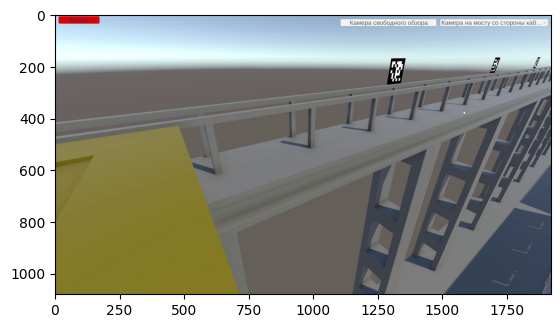

In [8]:
# Загрузка кадра с фронтальной камеры
image_front = 'demo_data/front.png'
image_front = cv2.imread(image_front)
plt.imshow(cv2.cvtColor(image_front, cv2.COLOR_BGR2RGB))
plt.show()

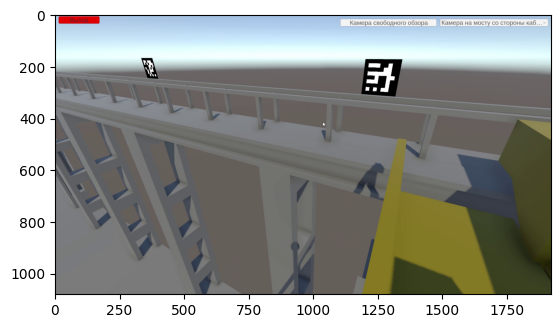

In [9]:
# Загрузка кадра с задней камеры
image_rear = 'demo_data/rear.png'
image_rear = cv2.imread(image_rear)
plt.imshow(cv2.cvtColor(image_rear, cv2.COLOR_BGR2RGB))
plt.show()

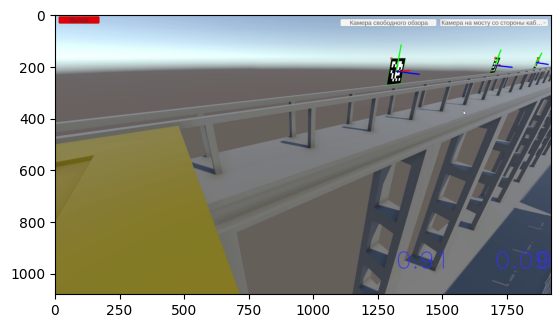

[[0.7930252315439317 -0.22428577457904297 0.5663981580621287
  -6.186527346815034]
 [0.6080517256407286 0.3482045379806395 -0.7134610701888515
  4.226452336085813]
 [-0.03720324018180915 0.9101920077935028 0.41251233662619896
  -0.7037128865995733]
 [0.0 0.0 0.0 1.0]]


In [10]:
frame, pose, size = estimator_front(image_front, True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

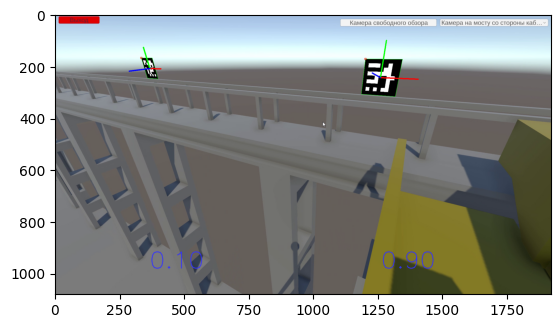

[[0.8702258729361412 0.1826887147800928 -0.4575278828274067
  10.48785474619335]
 [-0.4862879919946463 0.16973056064807907 -0.8571554850923511
  5.2250801405295055]
 [-0.07893616987380431 0.9684091956781942 0.23654325357440914
  0.4176306524175973]
 [0.0 0.0 0.0 1.0]]


In [11]:
frame, pose, size = estimator_rear(image_rear, True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

In [12]:
# ФПС
t1 = time()
for _ in range(100):
    frame, pose, size = estimator_rear(image_rear, True)
t2 = time()
print(t2-t1, 'sec, ', 100/(t2-t1), 'fps')

1.4389770030975342 sec,  69.49381385855405 fps


In [13]:
# А вот так без отрисовки детекции на фрейме
t1 = time()
for _ in range(100):
    frame, pose, size = estimator_rear(image_rear, False)
t2 = time()
print(t2-t1, 'sec, ', 100/(t2-t1), 'fps')

1.2891175746917725 sec,  77.57244332341831 fps


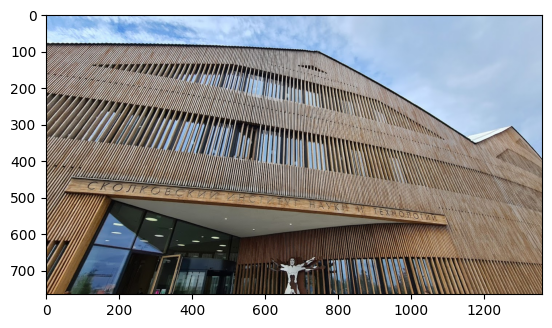

[[0.7930252315439317 -0.22428577457904297 0.5663981580621287
  -6.186527449111787]
 [0.6080517256407286 0.3482045379806395 -0.7134610701888515
  4.226452336085813]
 [-0.03720324018180915 0.9101920077935028 0.41251233662619896
  -0.7037128865995733]
 [0.0 0.0 0.0 1.0]]


In [15]:
# Предсказание при отсутствии обнаружения маркеров
# Возвращаются ПОСЛЕДНИЕ КООРДИНАТЫ
frame, pose, size = estimator_front(cv2.imread('demo_data/sk.jpg'), True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

In [16]:
# Создание экзмепляра класса PoseMultiple
estimator_mean = PoseMultiple(
    [estimator_front, estimator_rear])

In [18]:
# Случай, когда приходят два нона
estimator_mean([None, None])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [19]:
# Случай, когда приходит один нон и нет предсказания на втором фрейме
estimator_mean([None, cv2.imread('demo_data/sk.jpg')])

array([[ 0.87022587,  0.18268871, -0.45752788, 11.01487627],
       [-0.48628799,  0.16973056, -0.85715549,  5.22508014],
       [-0.07893617,  0.9684092 ,  0.23654325,  0.41763065],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [20]:
# Случай, когда приходит один нон и есть предсказание на втором фрейме
estimator_mean([None, image_rear])

array([[ 0.87022587,  0.18268871, -0.45752788, 11.01487935],
       [-0.48628799,  0.16973056, -0.85715549,  5.22508014],
       [-0.07893617,  0.9684092 ,  0.23654325,  0.41763065],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [21]:
# Случай, когда не предсказывает ни один эстимейтор
estimator_mean([cv2.imread('demo_data/sk.jpg'), cv2.imread('demo_data/sk.jpg')])

array([[ 0.83162555, -0.02079853,  0.05443514,  2.41421189],
       [ 0.06088187,  0.25896755, -0.78530828,  4.72576624],
       [-0.05806971,  0.9393006 ,  0.3245278 , -0.14304112],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [22]:
# Случай, когда предсказывают не все эстимейторы
estimator_mean([cv2.imread('demo_data/sk.jpg'), image_rear])

array([[ 0.83162555, -0.02079853,  0.05443514,  2.41421152],
       [ 0.06088187,  0.25896755, -0.78530828,  4.72576624],
       [-0.05806971,  0.9393006 ,  0.3245278 , -0.14304112],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [23]:
# Случай, когда предсказывают все эстимейторы
estimator_mean([image_front, image_rear])
# Во всех трех кейсах рехультат одинаковый
# так как при отсутствии детекции эстимейторы 
# возвращают координаты по последней детекции

array([[ 0.83162555, -0.02079853,  0.05443514,  2.33876267],
       [ 0.06088187,  0.25896755, -0.78530828,  4.72576624],
       [-0.05806971,  0.9393006 ,  0.3245278 , -0.14304112],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [19]:
# Кооридната X предсказания:
estimator_mean([image_front, image_rear])[0,3]

2.2126998439794594

In [20]:
# Настройка фильра Калмана
estimator_kf = PoseSingle(
    aruco_dict_type,
    -1,
    n_markers,
    marker_poses,
    edge_len,
    k,
    d,
    apply_kf=True, # по умолчанию и так True
    transition_coef=50,
    observation_coef=0.02,
)

In [21]:
# Специальный эстимейтор
# Special estimator

type_ = "DICT_5X5_50"

if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)

aruco_dict_type = ARUCO_DICT[type_]

special_estimator = PoseSpecial(
        aruco_dict_type = aruco_dict_type,
        marker_id = 38,
        marker_edge_len = 0.8,
        matrix_coefficients = k,
        distortion_coefficients = d,
        z_bias = 0,
        debug = False,
)

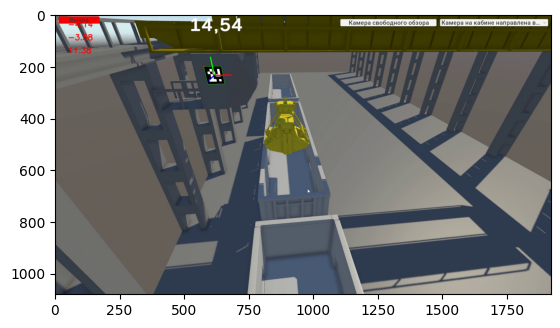

In [22]:
# Run on image
image_special = 'demo_data/special.png'

image_special = cv2.imread(image_special)

output, pose = special_estimator(image_special, return_frame = True)

output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

if pose.shape!=():
    output = display_pose(output, pose[:-1,[3]])
    
plt.imshow(output)
plt.show()

In [23]:
cv2.__version__

'4.8.1'